In [2]:
import torch
from torchvision import datasets,transforms
from torch.utils.data.sampler import SubsetRandomSampler
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

In [3]:
train_dir ='C:\\Users\\hp\\Celebrities\\training_set\\'

test_dir = 'C:\\Users\\hp\\Celebrities\\test_set\\'

transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(10),
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

valid_size = 0.2

In [9]:
trainset = datasets.ImageFolder(train_dir, transform = transform)
testset = datasets.ImageFolder(test_dir, transform = transform)

In [10]:
num_train = len(trainset)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(num_train*valid_size))
train_idx, valid_idx = indices[split:], indices[:split]

In [11]:
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

In [12]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=20, sampler=train_sampler, num_workers=0)

validloader = torch.utils.data.DataLoader(trainset, batch_size=20, sampler=valid_sampler, num_workers=0)

testloader = torch.utils.data.DataLoader(testset, batch_size=10, num_workers=0, shuffle=True)

In [13]:
classes = ('barkha', 'kajal', 'rakul', 'rashmika', 'samantha')

In [14]:
def imshow(x):
    x = x/2+0.5
    plt.imshow(np.transpose(x,(1,2,0)))

In [15]:
dataiterator = iter(trainloader)
images, labels = dataiterator.next()
images = images.numpy()

In [16]:
print(labels)
print(images.shape)

tensor([0, 3, 0, 3, 3, 1, 2, 3, 2, 4, 1, 2, 1, 0, 0, 0, 4, 2, 3, 0])
(20, 3, 224, 224)


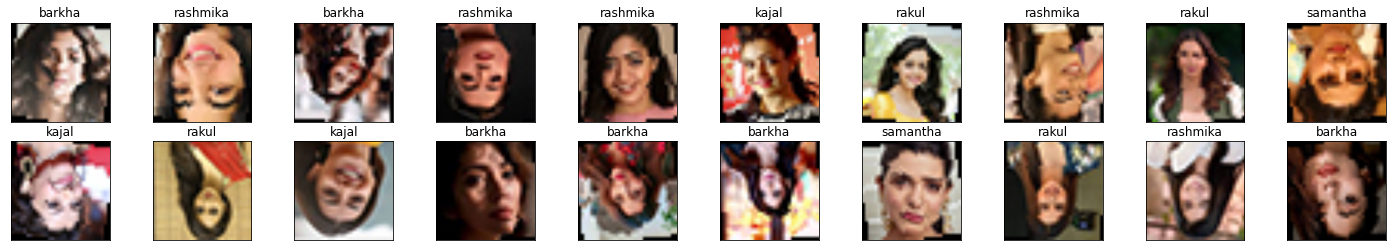

In [17]:
fig = plt.figure(figsize=(25,4))
for i in np.arange(20):
    img = fig.add_subplot(2,10,i+1,xticks=[],yticks=[])
    imshow(images[i])
    img.set_title(classes[labels[i]])

In [4]:
device = torch.cuda.is_available()

if device:
    print("The model trains on GPU")
else:
    print("The model trains on CPU")

The model trains on GPU


In [19]:
from torch import nn,optim
import torch.nn.functional as F

In [20]:
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier,self).__init__()
        
        self.conv1 = nn.Conv2d(3,16,3,padding=1)
        self.conv2 = nn.Conv2d(16,32,3,padding=1)
        self.conv3 = nn.Conv2d(32,64,3,padding=1)
        
        self.pool = nn.MaxPool2d(2,2)
        
        self.hidden1 = nn.Linear(28*28*64, 512)
        self.hidden2 = nn.Linear(512,256)
        self.hidden3 = nn.Linear(256,5)
        
        self.dropout = nn.Dropout(p=0.2)
        
    def forward(self,x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = F.relu(self.conv3(x))
        x = self.pool(x)
        
        x = x.view(-1, 28*28*64)
        
        x = self.dropout(x)
        
        x = self.hidden1(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.hidden2(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.hidden3(x)
        
        return x

In [21]:
model = Classifier()
model

Classifier(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (hidden1): Linear(in_features=50176, out_features=512, bias=True)
  (hidden2): Linear(in_features=512, out_features=256, bias=True)
  (hidden3): Linear(in_features=256, out_features=5, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

In [22]:
if device:
    model.cuda()

In [23]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(),lr=0.003)

In [24]:
epochs = 25
trainarr = []
validarr = []
testarr = []
min_valid_loss = np.Inf
for e in range(epochs):
    train_loss = 0
    valid_loss = 0
    model.train()
    for images,labels in trainloader:
        if device:
            images,labels = images.cuda(), labels.cuda()
        optimizer.zero_grad()
        
        output = model(images)
        loss = criterion(output,labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*images.size(0)
    
    model.eval()
    for images,labels in validloader:
        if device:
            images,labels = images.cuda(), labels.cuda()
            
        output  = model(images)
        loss = criterion(output,labels)
        valid_loss += loss.item()*images.size(0)
        
    train_loss += train_loss/len(trainloader.sampler)
    valid_loss += valid_loss/len(validloader.sampler)
    trainarr.append(train_loss/len(trainloader.sampler))
    validarr.append(valid_loss/len(validloader.sampler))
            
    print(f"Epoch : {e+1}")
    print(f"Training Loss : {train_loss}")
    print(f"Validation Loss : {valid_loss}")
    if valid_loss<min_valid_loss:
        print(f"Validation loss decreased from {min_valid_loss} --> {valid_loss}")
        print(f"Saving the model...")
        torch.save(model.state_dict(),'celebrity_model.pt')
        min_valid_loss = valid_loss

Epoch : 1
Training Loss : 66.08734411001205
Validation Loss : 17.65871250629425
Validation loss decreased from inf --> 17.65871250629425
Saving the model...
Epoch : 2
Training Loss : 66.05281335115433
Validation Loss : 17.654404878616333
Validation loss decreased from 17.65871250629425 --> 17.654404878616333
Saving the model...
Epoch : 3
Training Loss : 66.03929430246353
Validation Loss : 17.65902328491211
Epoch : 4
Training Loss : 66.07319211959839
Validation Loss : 17.65889346599579
Epoch : 5
Training Loss : 66.11873215436935
Validation Loss : 17.658438444137573
Epoch : 6
Training Loss : 66.00457048416138
Validation Loss : 17.66288113594055
Epoch : 7
Training Loss : 66.08552104234695
Validation Loss : 17.66004741191864
Epoch : 8
Training Loss : 66.04614180326462
Validation Loss : 17.66663932800293
Epoch : 9
Training Loss : 65.98745906352997
Validation Loss : 17.66730809211731
Epoch : 10
Training Loss : 66.03980749845505
Validation Loss : 17.666698336601257
Epoch : 11
Training Loss : 

In [25]:
loader = torch.load("celebrity_model.pt")
model.load_state_dict(loader)

<All keys matched successfully>

In [27]:
test_loss = 0.0
class_correct = list(0. for i in range(5))
class_total = list(0. for i in range(5))

model.eval()
for images, labels in testloader:
    if device:
        images, labels = images.cuda(), labels.cuda()
    
    output = model(images)
    loss = criterion(output, labels)
    test_loss += loss.item()*images.size(0)
    
    _, pred = torch.max(output, 1)    
    correct_tensor = pred.eq(labels.data.view_as(pred))
    
    correct = np.squeeze(correct_tensor.numpy()) if not device else np.squeeze(correct_tensor.cpu().numpy())
    
    for i in range(5):
        label = labels.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1


test_loss = test_loss/len(testloader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(5):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 1.609103

Test Accuracy of barkha:  0% ( 0/ 4)
Test Accuracy of kajal:  0% ( 0/ 2)
Test Accuracy of rakul:  0% ( 0/ 3)
Test Accuracy of rashmika:  0% ( 0/ 3)
Test Accuracy of samantha: 100% ( 3/ 3)

Test Accuracy (Overall): 20% ( 3/15)


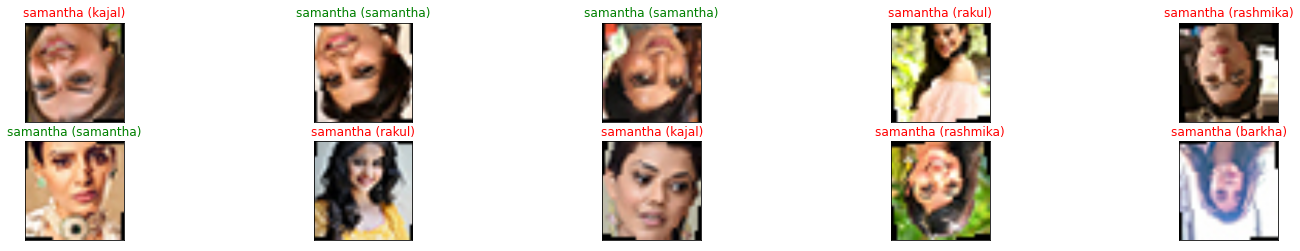

In [28]:
dataiter = iter(testloader)
images, labels = dataiter.next()
images.numpy()

if device:
    images = images.cuda()

output = model(images)

_, preds_tensor = torch.max(output, 1)
preds = np.squeeze(preds_tensor.numpy()) if not device else np.squeeze(preds_tensor.cpu().numpy())

fig = plt.figure(figsize=(25, 4))
for idx in np.arange(10):
    ax = fig.add_subplot(2, 5, idx+1, xticks=[], yticks=[])
    imshow(images.cpu()[idx])
    ax.set_title("{} ({})".format(classes[preds[idx]], classes[labels[idx]]),
                 color=("green" if preds[idx]==labels[idx].item() else "red"))